#### TODOS: 

    1. Data Augmentation
       a. Actual data may be combined with preprocessed data, if necessary
    2. Multiple models - compare accuracy/errors
    3. Visualization of intermediate layer weights

#### Importing required packages to be used in the notebook

In [1]:
# Generic
import os
import time

# Data analysis and computing
import csv
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer 
import random

# Image Processing
import PIL
from PIL import Image

# Visualisation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Pytorch
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision.models as models
from torch.nn.modules import CrossEntropyLoss, L1Loss
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms

#### Declaration of constants to be used in the notebook

In [2]:
# Declarations related to data and file paths
DATA_PATH = 'datasets/'
MOVIE_POSTERS_PATH = DATA_PATH + 'posters/'
MOVIE_GENRE_FILE = DATA_PATH + 'MovieGenre.csv'
TRAINED_MODEL_PATH = 'datasets/models/model3'

# Configurations related to training
DATASET_SIZE = 1000     # Set DATASET_SIZE to None use entire dataset
AUGMENT_RATIO = 2
TRAINING_SET_PROPORTION = 0.80
BATCH_SIZE = 50
LEARNING_RATE = 0.05123
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 50
DECAY_EPOCHS = 7
MOMENTUM = 0.9

WIDTH = 64
HEIGHT = 64
CHANNELS = 3

# GPU-related configurations 
USE_GPU = torch.cuda.is_available()
GPUS = [0, 1, 2]
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3"

In [3]:
if USE_GPU:
    torch.cuda.set_device(GPUS[0])

In [4]:
# Define the image processing functions

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])

toImage = transforms.ToPILImage()

preprocessFn = transforms.Compose([
#         transforms.RandomSizedCrop(WIDTH),
        transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         normalize
])

### Dataset Inspection

#### 1. Movie Genres

Read the Movie Genre file

In [5]:
data = []

with open(MOVIE_GENRE_FILE, 'r', encoding='latin1') as f:
    csv_reader = csv.reader(f)

    for row in csv_reader:
        data.append(row)

Print the first few entries to inspect the structure of data

In [6]:
data[0:5]

[['imdbId', 'Imdb Link', 'Title', 'IMDB Score', 'Genre', 'Poster'],
 ['114709',
  'http://www.imdb.com/title/tt114709',
  'Toy Story (1995)',
  '8.3',
  'Animation|Adventure|Comedy',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BMDU2ZWJlMjktMTRhMy00ZTA5LWEzNDgtYmNmZTEwZTViZWJkXkEyXkFqcGdeQXVyNDQ2OTk4MzI@._V1_UX182_CR0,0,182,268_AL_.jpg'],
 ['113497',
  'http://www.imdb.com/title/tt113497',
  'Jumanji (1995)',
  '6.9',
  'Action|Adventure|Family',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BZTk2ZmUwYmEtNTcwZS00YmMyLWFkYjMtNTRmZDA3YWExMjc2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UY268_CR10,0,182,268_AL_.jpg'],
 ['113228',
  'http://www.imdb.com/title/tt113228',
  'Grumpier Old Men (1995)',
  '6.6',
  'Comedy|Romance',
  'https://images-na.ssl-images-amazon.com/images/M/MV5BMjQxM2YyNjMtZjUxYy00OGYyLTg0MmQtNGE2YzNjYmUyZTY1XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_UX182_CR0,0,182,268_AL_.jpg'],
 ['114885',
  'http://www.imdb.com/title/tt114885',
  'Waiting to Exhale (1995)',
  '5.7',
 

Create a dataframe from the data, using the entries at the first index as the column headers

In [7]:
columns = data.pop(0)

columns = list(map(lambda x: x.lower().replace(' ', '_'), columns))
movie_genre_df = pd.DataFrame(data, columns=columns)

Inspect the dataframe

In [8]:
movie_genre_df.shape

(40108, 6)

Clean the movie genre dataset to only contain relevant samples

In [9]:
# Drop duplicates
movie_genre_df.drop_duplicates(inplace=True)
# Drop those samples that do not have an associated genre
movie_genre_df.drop(movie_genre_df[movie_genre_df['genre'] == ''].index, inplace=True)
# Drop those samples that do not have an associated poster
movie_genre_df.drop(movie_genre_df[movie_genre_df['poster'] == ''].index, inplace=True)
# Reset the indices on the dataframe
movie_genre_df.reset_index(drop=True, inplace=True)

In [10]:
movie_genre_df.shape

(38671, 6)

In [11]:
movie_genre_df.head()

,imdbid,imdb_link,title,imdb_score,genre,poster
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...


Process the dataframe so that genres can be accessed easily further on 

In [12]:
# Split genre to create a list of values 
movie_genre_df['genre'] = movie_genre_df['genre'].apply(lambda x: x.split('|'))

# Expand genre into its own dataframe
tags = movie_genre_df['genre'].apply(pd.Series).fillna('')

# Rename the columns
tags = tags.rename(columns = lambda x : 'genre_' + str(x))

# Merge the genre dataframe back into the original dataframe
movie_genre_df = pd.concat([movie_genre_df[:], tags[:]], axis=1)

Inspect the dataframe

In [13]:
movie_genre_df.shape

(38671, 9)

In [14]:
movie_genre_df.head()

,imdbid,imdb_link,title,imdb_score,genre,poster,genre_0,genre_1,genre_2
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,"[Animation, Adventure, Comedy]",https://images-na.ssl-images-amazon.com/images...,Animation,Adventure,Comedy
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,"[Action, Adventure, Family]",https://images-na.ssl-images-amazon.com/images...,Action,Adventure,Family
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,"[Comedy, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Romance,
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,"[Comedy, Drama, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Drama,Romance
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,"[Comedy, Family, Romance]",https://images-na.ssl-images-amazon.com/images...,Comedy,Family,Romance


Retrieve the distribution of unique genres across all movies

In [15]:
# Get distribution of unique values from multiple genre columns
# Remove the entry representing no genre
# Get combined counts of unique genres

genre_distribution = movie_genre_df[['genre_0', 'genre_1', 'genre_2']] \
            .apply(lambda s: s.value_counts()) \
            .drop('') \
            .sum(axis=1) \
            .reset_index()
                
# Rename the columns acordingly                
genre_distribution.columns = ['genre', 'count']

# Sort the dataframe to order by predominant genres 
genre_distribution = genre_distribution.sort_values(by='count', ascending=False).reset_index(drop=True)

# Store the unique genres as a dictionary
unique_genres = genre_distribution['genre'].tolist()
unique_genres = {x: i for (i,x) in enumerate(unique_genres)}

multi_label_binarizer = MultiLabelBinarizer(list(unique_genres.keys()))

# unique_genres[''] = len(unique_genres)

Visualise the distribution of genres across movies

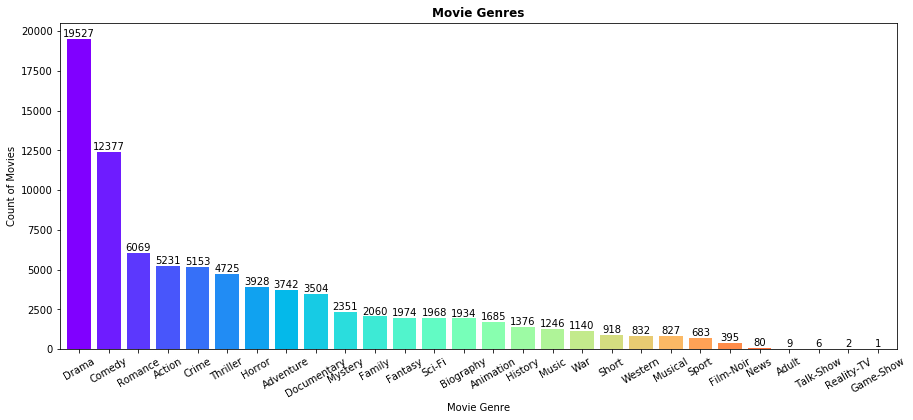

In [16]:
genres_count = genre_distribution.shape[0]
colors = cm.rainbow(np.linspace(0, 1, genres_count))


plot = genre_distribution.plot(x='genre', y='count', kind='bar', width=0.8, rot=0, figsize=(15,6), 
                               color=colors, legend=None)

plot.set_title('Movie Genres', fontweight='bold')

plot.set_ylabel('Count of Movies')
plot.set_xlabel('Movie Genre')

plot.set_xticklabels(labels=genre_distribution['genre'], rotation=30)

rects = plot.patches

# Now make some labels
labels = [int(genre_distribution['count'][i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plot.get_figure() #.save_fig('')

In [17]:
movie_genre_df.shape

(38671, 9)

Mark the movies that need to be augmented as they belong to minority classes 

In [18]:
# Fetch those genres that consist of fewer then X(say 10000) samples
genres_partial = set(genre_distribution[genre_distribution['count'] < 10000]['genre'].tolist())
# Label the movies based on their genres
movie_genre_df['no_augment'] = movie_genre_df['genre'].apply(lambda x: bool(set(x) - genres_partial))

augment_movie_genre_df = (movie_genre_df[movie_genre_df['no_augment'] == False])

In [19]:
augment_movie_genre_df.shape

(10907, 10)

In [20]:
# Get distribution of unique values from multiple genre columns
# Remove the entry representing no genre
# Get combined counts of unique genres

augment_genre_distribution = augment_movie_genre_df[['genre_0', 'genre_1', 'genre_2']] \
            .apply(lambda s: s.value_counts()) \
            .drop('') \
            .sum(axis=1) \
            .reset_index()
                
# Rename the columns acordingly                
augment_genre_distribution.columns = ['genre', 'count']

# Sort the dataframe to order by predominant genres 
augment_genre_distribution = augment_genre_distribution.sort_values(by='count', ascending=False) \
                                    .reset_index(drop=True)

Visualise the distribution of genres across movies

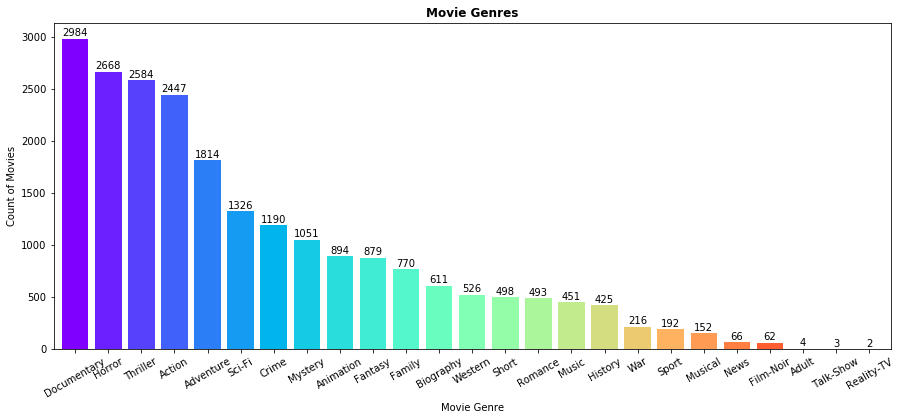

In [21]:
genres_count = augment_genre_distribution.shape[0]
colors = cm.rainbow(np.linspace(0, 1, genres_count))


plot = augment_genre_distribution.plot(x='genre', y='count', kind='bar', width=0.8, rot=0, figsize=(15,6), 
                               color=colors, legend=None)

plot.set_title('Movie Genres', fontweight='bold')

plot.set_ylabel('Count of Movies')
plot.set_xlabel('Movie Genre')

plot.set_xticklabels(labels=augment_genre_distribution['genre'], rotation=30)

rects = plot.patches

# Now make some labels
labels = [int(augment_genre_distribution['count'][i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    plot.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plot.get_figure() #.save_fig('')

#### 2. Movie Posters

Create a list of the movie posters names by traversing the directory

In [22]:
valid_poster_files = set(os.listdir(MOVIE_POSTERS_PATH))
valid_movie_samples = set(movie_genre_df['imdbid'].apply(lambda x: x+'.jpg').tolist())
augment_valid_movie_samples = set(augment_movie_genre_df['imdbid'].apply(lambda x: x+'.jpg').tolist())

poster_files = valid_poster_files.intersection(valid_movie_samples)
augment_poster_files = valid_poster_files.intersection(augment_valid_movie_samples)

imdb_ids = [i.split('.')[0] for i in poster_files]
movie_posters = [MOVIE_POSTERS_PATH + i for i in poster_files] # if os.path.getsize(MOVIE_POSTERS_PATH + i) > 0]

augment_imdb_ids = [i.split('.')[0] for i in augment_poster_files]
augment_movie_posters = [MOVIE_POSTERS_PATH + i for i in augment_poster_files]

print("Number of movie posters =", len(movie_posters))
print("Number of augment movie posters =", len(augment_movie_posters))

Number of movie posters = 38533
Number of augment movie posters = 10865


Create a mini-batch of posters and associated genres.

In [23]:
range_movies = list(range(len(movie_posters)))
range_augment_movies = list(range(len(augment_movie_posters)))

sample_movies = random.sample(range_movies, DATASET_SIZE//AUGMENT_RATIO)
sample_augment_movies = random.sample(range_augment_movies, DATASET_SIZE - DATASET_SIZE//AUGMENT_RATIO)

In [24]:
mini_batch_posters = [movie_posters[i] for i in sample_movies]
mini_batch_imdb_ids = [imdb_ids[i] for i in sample_movies]

mini_batch_genres = [movie_genre_df[movie_genre_df['imdbid'] == i]['genre'].item() for i in mini_batch_imdb_ids]

augment_mini_batch_posters = [augment_movie_posters[i] for i in sample_augment_movies]
augment_mini_batch_imdb_ids = [augment_imdb_ids[i] for i in sample_augment_movies]

augment_mini_batch_genres = [augment_movie_genre_df[augment_movie_genre_df['imdbid'] == i]['genre'].item() \
                                 for i in augment_mini_batch_imdb_ids]

num_classes = len(unique_genres)

print("Number of movie posters =", len(mini_batch_posters))
print("Number of augment movie posters =", len(augment_mini_batch_posters))

Number of movie posters = 500
Number of augment movie posters = 500


Inspect the dimensions of one of the posters

In [25]:
print("Poster dimensions :", np.array(PIL.Image.open(mini_batch_posters[0])).shape)

Poster dimensions : (268, 182, 3)


### Dataset preparation

Partition the data into training and test sets

In [26]:
train_size = int(len(mini_batch_posters)*TRAINING_SET_PROPORTION)

train_posters = mini_batch_posters[:train_size]
test_posters = mini_batch_posters[train_size:]

X_train = torch.FloatTensor(train_size, CHANNELS, HEIGHT, WIDTH).zero_()
X_test = torch.FloatTensor(len(mini_batch_posters) - train_size, CHANNELS, HEIGHT, WIDTH).zero_()

# Resize the posters as square images are nice to work with and also apply necessary pre-processing
for i, poster in enumerate(train_posters):
    X_train[i] = torch.from_numpy(np.transpose(np.array(PIL.Image.open(poster).resize((WIDTH,HEIGHT))).T, (0,2,1))) \
                        .float().unsqueeze(0)

for i, poster in enumerate(test_posters):
    X_test[i] = torch.from_numpy(np.transpose(np.array(PIL.Image.open(poster).resize((WIDTH,HEIGHT))).T, (0,2,1))) \
                       .float().unsqueeze(0)
        
y = multi_label_binarizer.fit_transform(mini_batch_genres)
y_train = torch.from_numpy(y[:train_size])
y_test = torch.from_numpy(y[train_size:])

In [27]:
augment_train_size = int(len(augment_mini_batch_posters)*TRAINING_SET_PROPORTION)

augment_train_posters = augment_mini_batch_posters[:augment_train_size]
augment_test_posters = augment_mini_batch_posters[augment_train_size:]

augment_X_train = torch.FloatTensor(augment_train_size, CHANNELS, HEIGHT, WIDTH).zero_()
augment_X_test = torch.FloatTensor(len(augment_mini_batch_posters) - augment_train_size, \
                                   CHANNELS, HEIGHT, WIDTH).zero_()

for i, poster in enumerate(augment_train_posters):
    augment_X_train[i] = torch.from_numpy(np.transpose(np.array(preprocessFn(PIL.Image.open(poster)) \
                                            .resize((WIDTH,HEIGHT))).T, (0,2,1))).float().unsqueeze(0)

for i, poster in enumerate(augment_test_posters):
    augment_X_test[i] = torch.from_numpy(np.transpose(np.array(PIL.Image.open(poster) \
                                            .resize((WIDTH,HEIGHT))).T, (0,2,1))).float().unsqueeze(0)
    
augment_y = multi_label_binarizer.fit_transform(augment_mini_batch_genres)
augment_y_train = torch.from_numpy(augment_y[:augment_train_size])
augment_y_test = torch.from_numpy(augment_y[augment_train_size:])

Visualise few movie posters

In [28]:
markup = '<table>'

temp_genres = mini_batch_genres + augment_mini_batch_genres

for i, poster in enumerate(mini_batch_posters + augment_mini_batch_posters):
    if i%12 == 0:
        markup += '</tr/><tr>'

    markup += '<td><img src=' + poster +' width="70" height="70"/><span>' + ',\n'.join(temp_genres[i]) + \
                            '</span</td>'
    
markup += '</table>'

display(HTML(markup))

"Action, Adventure, Family</span",Drama</span,"Animation, Action, Adventure</span",Drama</span,"Documentary, Comedy</span",Drama</span,Comedy</span,"Comedy, Music</span","Adventure, Biography, Drama</span",Drama</span,"Drama, War</span","Comedy, Drama</span"
Romance</span,"Drama, History, Thriller</span",Drama</span,"Romance, Thriller</span","Comedy, Horror, Musical</span","Drama, Romance</span",Drama</span,"Comedy, Fantasy, Horror</span","Comedy, Family, Fantasy</span","Comedy, Crime</span","Action, Comedy, Crime</span","Drama, Romance</span"
"Comedy, Drama</span",Drama</span,"Drama, History, Romance</span","Drama, Romance</span",Drama</span,"Crime, Music, Mystery</span","Documentary, Biography, Family</span","Comedy, Drama, Romance</span","Biography, Drama, Romance</span","Adventure, Family</span",Drama</span,Comedy</span
Documentary</span,"Adventure, Drama, Musical</span","Documentary, News</span","Crime, Drama, Thriller</span","Biography, Comedy, Drama</span","Comedy, Crime</span","Drama, Romance</span","Adventure, Comedy, Family</span",Drama</span,Drama</span,"Comedy, Family</span","Action, Comedy</span"
"Action, Crime, Drama</span",Drama</span,Action</span,"Drama, Sport</span","Comedy, Drama, Sci-Fi</span",Comedy</span,Horror</span,"Action, Comedy, Crime</span",Drama</span,"Animation, Family, Fantasy</span","Comedy, Drama, Romance</span","Comedy, Crime, Drama</span"
"Crime, Drama, Thriller</span","Animation, Short, Drama</span","Drama, Romance</span","Biography, Drama</span",Drama</span,"Comedy, Musical</span","Comedy, Romance</span",Action</span,Comedy</span,Documentary</span,"Comedy, Drama, Romance</span",Comedy</span
"Adventure, Comedy, Musical</span","Action, Crime, Drama</span","Action, Drama, Romance</span",Drama</span,"Drama, Thriller</span",Drama</span,"Animation, Adventure, Drama</span","Action, Drama</span","Horror, Mystery, Thriller</span","Animation, Action, Adventure</span",Musical</span,"Action, Adventure, Thriller</span"
Comedy</span,"Biography, Drama, Family</span","Comedy, Family</span","Adventure, Family, Fantasy</span","Documentary, Crime, Drama</span",Comedy</span,Drama</span,Drama</span,Comedy</span,"Action, Sci-Fi</span",Drama</span,"Comedy, Fantasy, Romance</span"
"Animation, Action, Sci-Fi</span",Drama</span,Comedy</span,"Comedy, Drama, Romance</span",Comedy</span,"Action, Crime, Drama</span",Comedy</span,Mystery</span,"Action, Crime, Drama</span","Adventure, Biography, Drama</span","Action, Comedy, Crime</span","Animation, Action, Fantasy</span"
"Animation, Family</span","Crime, Drama, Romance</span","Romance, Comedy, Drama</span","Crime, Horror, Mystery</span","Animation, Family, Music</span","Drama, Romance</span",Documentary</span,Comedy</span,"Documentary, Biography</span","Comedy, Romance, Drama</span","Animation, Fantasy</span",Drama</span
"Drama, Romance</span",Documentary</span,"Animation, Horror, Sci-Fi</span",Drama</span,"Drama, Romance</span","Comedy, Romance</span","Drama, Romance</span","Action, Crime, Drama</span","Comedy, Drama</span",Drama</span,Horror</span,"Animation, Short, Action</span"


In [29]:
X_train = torch.cat((X_train, augment_X_train))
X_test = torch.cat((X_test, augment_X_test))

y_train = torch.cat((y_train, augment_y_train))
y_test = torch.cat((y_test, augment_y_test))


print("X_train shape: ", X_train.size())
print("y_train shape: ", y_train.size())
print("X_test shape: ", X_test.size())
print("y_test shape: ", y_test.size())

X_train shape:  torch.Size([800, 3, 64, 64])
y_train shape:  torch.Size([800, 28])
X_test shape:  torch.Size([200, 3, 64, 64])
y_test shape:  torch.Size([200, 28])


Create Tensor objects for the training and test sets

In [30]:
train = data_utils.TensorDataset(X_train, y_train)

# Use weight-sampling to account for class-imbalance
class_sample_count = [int(genre_distribution[genre_distribution['genre'] == x]['count'].values[0]) \
                          for x in multi_label_binarizer.classes]
weights = (1 / torch.Tensor(class_sample_count)).double()
sampler = data_utils.sampler.WeightedRandomSampler(weights, train_size)
train_loader = data_utils.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)#, sampler = sampler)

test = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

dataset_sizes = {'train': len(train), 'val': 0, 'test': len(test)}

### Network Architecture

Define a custom architecture on top of the pre-trained model.

Since the dataset is small, it is not a good idea to fine-tune the entire ConvNet due to overfitting concerns.
As the dataset is very different from the ImageNet dataset, it might not be best to train the classifier from the top of the network, which contains more dataset-specific features. Instead, it might work better to train the classifier from activations somewhere earlier in the network.

In [31]:
class CustomNet(nn.Module):
    def __init__(self, model, freeze='all'):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(CustomNet, self).__init__()
        self.model = model
        
        if freeze == 'all':
            for param in self.model.parameters():
                param.requires_grad = False
        else:
            for layer in freeze:
                for param in getattr(self.model, layer).parameters():
                    param.requires_grad = False

        self.model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)


    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        x = self.model(x)
#         x = nn.functional.softmax(x)
        return x

Define the **train** and **test** functions

In [32]:
def exp_lr_scheduler(optimizer, epoch, init_lr=LEARNING_RATE, lr_decay_epoch=DECAY_EPOCHS):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (WEIGHT_DECAY**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [33]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    
    start = time.time()
    loss_history = []
    
    
    for epoch in range(NUM_EPOCHS):
        
        optimizer = lr_scheduler(optimizer, epoch)
        # Set model to training mode
        model.train(True)  

        running_loss = []

        # Iterate over data.
        for batch_idx, (inputs, targets) in enumerate(train_loader):

            if USE_GPU:
                inputs = Variable(inputs.cuda()).float()
                targets = Variable(targets.cuda()).float()
            else:
                inputs = Variable(inputs)
                targets = Variable(targets).float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            running_loss.append(loss.data[0])

        epoch_loss = np.mean(running_loss)
        loss_history.append(epoch_loss)

        print('Epoch {}/{}'.format(epoch, NUM_EPOCHS - 1), 'Training loss: {:.4f}'.format(epoch_loss))
        print('-' * 10)
        
    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
#     torch.save(model.state_dict(), TRAINED_MODEL_PATH)
    
    return model, loss_history

In [34]:
def test_model(model):
    
    start = time.time()
    num_labels = []
    num_preds = []
    num_labels_union = []
    preds_correct = []
    diff_labels = []
    target_labels = []
    predicted_labels = []
    data_inputs = []
    
    # Set model to training mode
    model.train(False)  

    # Iterate over data
    for batch_idx, (inputs, targets) in enumerate(test_loader):

        if USE_GPU:
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda()).float()
        else:
            inputs = Variable(inputs)
            targets = Variable(targets).float()

        # forward
        outputs = model(inputs)
        
        for i, t in enumerate(targets.data):
            labels = t.nonzero()[:,0].tolist()
            
            num_labels.append(len(labels)) 
            
            j, preds = torch.exp(outputs.data[i]).topk(num_labels[-1])
            preds = [p for k, p in enumerate(preds) if j[k] != 0.0]

            data_inputs.append(inputs.data[i])
            target_labels.append([multi_label_binarizer.classes[i] for i in labels])
            predicted_labels.append([multi_label_binarizer.classes[i] for i in preds])
            
            preds_correct.append(len(set(preds).intersection(labels))) 
            num_preds.append(len(preds))
            num_labels_union.append(len(set(preds).union(labels)))
            diff_labels.append(len(set(preds).symmetric_difference(labels)))

    
    total_preds_correct = sum(preds_correct)
    total_num_labels = sum(num_labels)
    total_num_preds = sum(num_preds)
    
    label_cardinality = np.mean(num_labels)
    label_density = np.mean([i/total_num_labels for i in num_labels])
    
    precision = np.mean([x/num_preds[i] for i,x in enumerate(preds_correct) if num_preds[i] != 0])
    recall = np.mean([x/num_labels[i] for i,x in enumerate(preds_correct)])
    f1_score = (2*precision*recall)/(precision+recall)
    
    jaccard_index = np.mean([x/num_labels_union[i] for i,x in enumerate(preds_correct)])
    hamming_loss = np.mean([x/total_num_labels for i,x in enumerate(diff_labels)])
    
    time_elapsed = time.time() - start
    
    result = {
        'label_cardinality': label_cardinality,
        'label_density': label_density,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'jaccard_index': jaccard_index,
        'hamming_loss': hamming_loss,
        'total_num_labels': total_num_labels,
        'total_num_preds': total_num_preds,
        'total_preds_correct': total_preds_correct,
        'target_labels': target_labels,
        'predicted_labels': predicted_labels,
        'data_inputs': data_inputs
    }
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return result

Download pretrained models and adapt them by fine-tuning

In [35]:
pretrained_models = {
    'resnet': {
        'model': models.resnet152(pretrained=True),
#         'freeze': 'all'
        'freeze': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']
    }
#     'alexnet': {
#         'model': models.alexnet(pretrained=True)
#     },
#     'vggnet': {
#         'model': models.vgg16(pretrained=True)
#     }
}

Define the parameters required for training the model

In [36]:
base_model = pretrained_models['resnet']
custom_model = CustomNet(base_model['model'], base_model['freeze'])

if USE_GPU:
    print('Using GPU...', torch.cuda.current_device())
    custom_model = custom_model.cuda()

print('Custom Model', custom_model)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.SGD([
                {'params': custom_model.model.layer4.parameters()},
                {'params': custom_model.model.avgpool.parameters()},
                {'params': custom_model.model.fc.parameters()}
            ], lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, momentum=MOMENTUM)

Using GPU... 0
Custom Model CustomNet (
  (model): ResNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): Bottleneck (
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (downsample): Sequential (
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1):

### Deep Learning in Action

#### 1. Train the model

In [37]:
best_model, loss_history = train_model(custom_model, criterion, optimizer, exp_lr_scheduler, \
                                             num_epochs=NUM_EPOCHS)

LR is set to 0.05123
Epoch 0/49 Training loss: 0.3479
----------
Epoch 1/49 Training loss: 0.2367
----------
Epoch 2/49 Training loss: 0.1820
----------
Epoch 3/49 Training loss: 0.1449
----------
Epoch 4/49 Training loss: 0.1126
----------
Epoch 5/49 Training loss: 0.0871
----------
Epoch 6/49 Training loss: 0.0683
----------
LR is set to 5.123e-06
Epoch 7/49 Training loss: 0.0556
----------
Epoch 8/49 Training loss: 0.0557
----------
Epoch 9/49 Training loss: 0.0553
----------
Epoch 10/49 Training loss: 0.0555
----------
Epoch 11/49 Training loss: 0.0556
----------
Epoch 12/49 Training loss: 0.0550
----------
Epoch 13/49 Training loss: 0.0559
----------
LR is set to 5.123e-10
Epoch 14/49 Training loss: 0.0550
----------
Epoch 15/49 Training loss: 0.0558
----------
Epoch 16/49 Training loss: 0.0564
----------
Epoch 17/49 Training loss: 0.0559
----------
Epoch 18/49 Training loss: 0.0570
----------
Epoch 19/49 Training loss: 0.0561
----------
Epoch 20/49 Training loss: 0.0556
---------

#### 2. Visualise the training loss over epochs

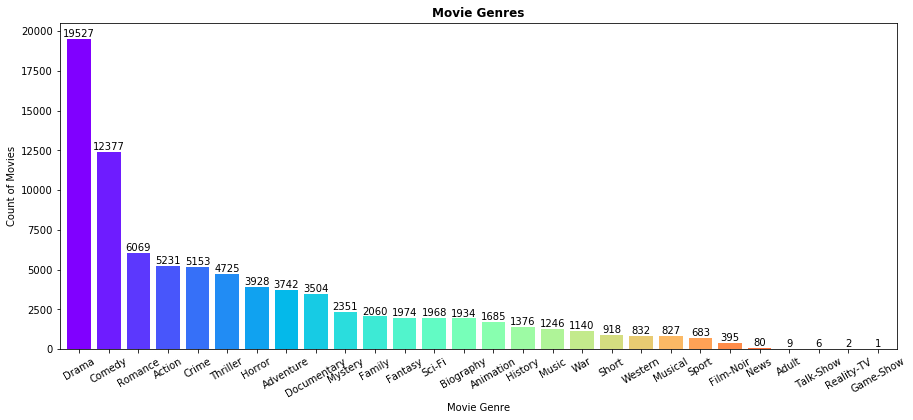

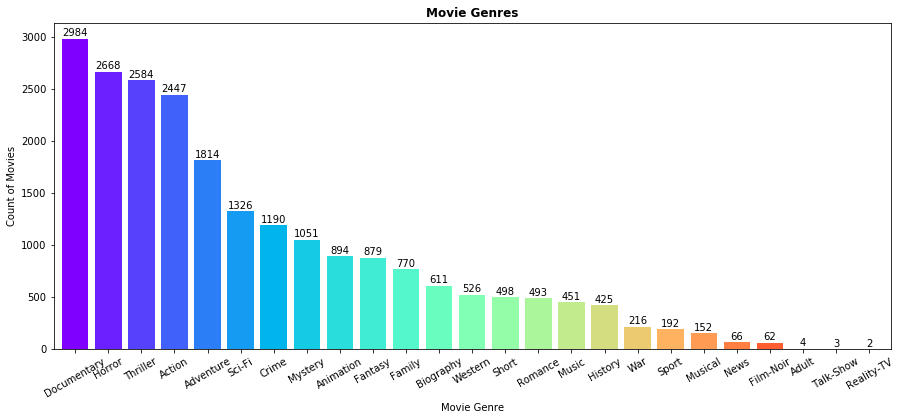

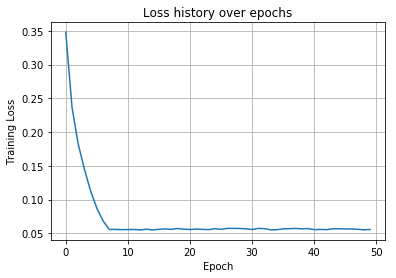

In [38]:
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), loss_history)

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss history over epochs')

plt.grid(True)
plt.show()

#### 3. Use the model to get predictions on the test set

In [39]:
result = test_model(best_model)

Testing complete in 0m 0s


In [40]:
result['f1_score'], result['hamming_loss'], result['jaccard_index'], result['precision'], result['recall']
# result['label_cardinality'], result['label_density']

(0.25750000000000001,
 0.0074082568807339452,
 0.20366666666666666,
 0.25750000000000001,
 0.25750000000000001)

In [41]:
# torch.save(best_model.state_dict(), TRAINED_MODEL_PATH)

In [42]:
result['target_labels'][15], result['predicted_labels'][15]

(['Drama', 'Romance'], ['Family', 'Adventure'])

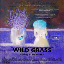

In [43]:
toImage(result['data_inputs'][15].cpu())